In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

In [2]:
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df["CATEGORY"])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0, stratify=valid_test["CATEGORY"])
print(train["CATEGORY"].value_counts())
print(valid["CATEGORY"].value_counts())
print(valid["CATEGORY"].value_counts())

b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64


In [3]:
import string
import re

def preprocessing(text):
    table = str.maketrans(string.punctuation, " "*len(string.punctuation))
    text = text.translate(table)#記号をスペース変換
    text = text.lower()
    text = re.sub('[0-9]+', "0", text)
    
    return text

df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)

df["TITLE"] = df["TITLE"].map(lambda x: preprocessing(x))
df.head()

,TITLE,CATEGORY
0,tesla is not ing around with fires anymore,t
1,angelina jolie lifts the lid on rock solid rel...,e
2,update 0 adidas hit by sales drop at golf busi...,b
3,julia roberts julia roberts opens up about h...,e
4,transformers age of extinction reviewed ...,e


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

X_train_valid = vec_tfidf.fit_transform(train_valid["TITLE"])
X_test = vec_tfidf.transform(test["TITLE"])

X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())


X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

X_train.head()

,0k,0m,0million,0nd,0s,0st,0th,aa,aaliyah,abbvie,...,you to,young,your,your mother,yr,yuan,zac,zac efron,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=0, max_iter=10000)
lg.fit(X_train, train["CATEGORY"])

LogisticRegression(max_iter=10000, random_state=0)

In [6]:
import numpy as np
def score_lg(lg, X):
    return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [7]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)
print(train_pred)

[array([0.39095806, 0.95758832, 0.96204618, ..., 0.88318381, 0.83899073,
       0.8224719 ]), array(['t', 'e', 'b', ..., 'e', 'b', 'e'], dtype=object)]


In [8]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train["CATEGORY"], train_pred[1])
test_accuracy = accuracy_score(test["CATEGORY"], test_pred[1])
print(f'正解率(学習データ):{train_accuracy:.3f}')
print(f'正解率(テストデータ):{test_accuracy:.3f}')

正解率(学習データ):0.928
正解率(テストデータ):0.884


[[4355   91    9   46]
 [  49 4173    3   10]
 [  93  130  490   15]
 [ 189  132    7  892]]


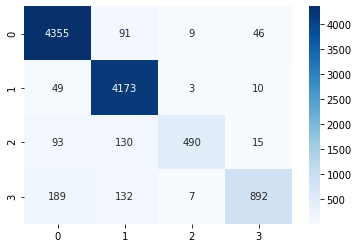

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_cm = confusion_matrix(train["CATEGORY"], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap="Blues", fmt=".4g")
plt.show()

[[525  24   1  13]
 [ 12 513   2   3]
 [ 13  28  45   5]
 [ 26  25   3  98]]


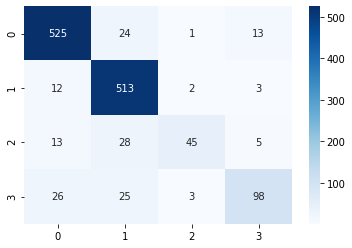

In [10]:
test_cm = confusion_matrix(test["CATEGORY"], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, fmt=".4g", cmap="Blues")
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_score(y_true, y_pred):
    precision = precision_score(test["CATEGORY"], test_pred[1],
                                average=None, labels=["b", "e", "t", "m"])
    precision = np.append(precision, precision_score(y_true, y_pred, average="micro"))
    precision = np.append(precision, precision_score(y_true, y_pred, average="macro"))
    
    
    recall = recall_score(test["CATEGORY"], test_pred[1], 
                         average=None, labels=["b", "e", "t", "m"])
    recall = np.append(recall, recall_score(y_true, y_pred, average="micro"))
    recall = np.append(recall, recall_score(y_true, y_pred, average="macro"))    
    
    f1 = f1_score(test["CATEGORY"], test_pred[1], 
                         average=None, labels=["b", "e", "t", "m"])
    f1 = np.append(f1, f1_score(y_true, y_pred, average="micro"))
    f1 = np.append(f1, f1_score(y_true, y_pred, average="macro"))    

    scores = pd.DataFrame({"適合率":precision, "再現率":recall, "f１スコア":f1},
                         index=["b", "e", "t", "m", "マイクロ平均", "マクロ平均"])
    
    return scores

In [12]:
print(calculate_score(test["CATEGORY"], test_pred[1]))

             適合率       再現率     f１スコア
b       0.911458  0.932504  0.921861
e       0.869492  0.967925  0.916071
t       0.823529  0.644737  0.723247
m       0.882353  0.494505  0.633803
マイクロ平均  0.883982  0.883982  0.883982
マクロ平均   0.871708  0.759918  0.798746


In [13]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
    
    print(f'【カテゴリ】{c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
    display(pd.concat([best10, worst10], axis=0))
    print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,fed,bank,china,ecb,stocks,euro,ukraine,yellen,oil,obamacare
重要度下位,and,video,ebola,her,aereo,the,microsoft,she,study,this




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,she,movie,film,wedding,he,paul,jay
重要度下位,update,us,google,china,gm,apple,study,ceo,facebook,billion




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,fda,cancer,mers,drug,cases,cdc,health,could
重要度下位,facebook,gm,apple,climate,ceo,sales,google,deal,cars,amazon




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,heartbleed,tesla,mobile
重要度下位,stocks,fed,shares,cancer,her,ukraine,his,percent,ecb,american


In [14]:
from tqdm import tqdm
result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    lg = LogisticRegression(random_state=0, max_iter=10000, C=C)
    lg.fit(X_train, train["CATEGORY"])
    
    train_pred = score_lg(lg, X_train)
    valid_pred = score_lg(lg, X_valid)
    test_pred = score_lg(lg, X_test)
    
    train_accuracy = accuracy_score(train["CATEGORY"], train_pred[1])
    valid_accuracy = accuracy_score(valid["CATEGORY"], valid_pred[1])    
    test_accuracy = accuracy_score(test["CATEGORY"], test_pred[1])    
    
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


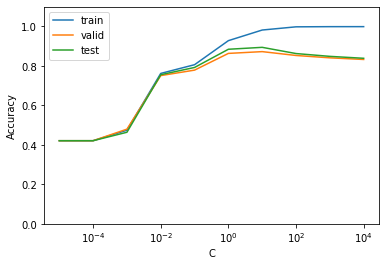

In [15]:
result = np.array(result).T
plt.plot(result[0], result[1], label="train")
plt.plot(result[0], result[2], label="valid")
plt.plot(result[0], result[3], label="test")
plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.xscale("log")
plt.xlabel("C")
plt.legend()
plt.show()

In [16]:
import optuna

def objective_lg(trial):
    l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    C = trial.suggest_loguniform("C", 1e-4, 1e4)
    lg = LogisticRegression(random_state=0,
                           max_iter=1000,
                           penalty="elasticnet",
                           solver="saga",
                           l1_ratio = l1_ratio,
                           C=C)
    lg.fit(X_train, train["CATEGORY"])
    
    valid_pred = score_lg(lg, X_valid)
    valid_accuracy = accuracy_score(valid["CATEGORY"], valid_pred[1])
    return valid_accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lg, timeout=300)

print("Best Trial:")
trial = study.best_trial
print("Value:{:.3f}".format(trial.value))
print("Param")
for key, value in trial.params.item():
    print("{}:{}".format(key, value))

[I 2021-01-29 01:38:51,209] A new study created in memory with name: no-name-559f5e4a-c367-4d02-ade6-64d21ac56442
[I 2021-01-29 01:39:12,742] Trial 0 finished with value: 0.5276946107784432 and parameters: {'l1_ratio': 0.9158386123107798, 'C': 0.022686887114026312}. Best is trial 0 with value: 0.5276946107784432.
